In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

# Get the data

In [36]:
# downloaded from: https://www.kaggle.com/c/competitive-data-science-final-project/data
item_categories =   pd.read_csv('../data/item_categories.csv')
items             = pd.read_csv('../data/items.csv')
shops             = pd.read_csv('../data/shops.csv')
sales_train       = pd.read_csv('../data/sales_train.csv.gz')
sample_submission = pd.read_csv('../data/sample_submission.csv.gz') # scores 1.23646 
test              = pd.read_csv('../data/test.csv.gz')

# Check data types

The data types we've got look OK, except:
 - the various IDs are currently int64, which is not ideal since this is categorical data without a natural ordering
 - the dates are "objects"

We'll fix dates now, since that's pretty trivial, but handle the IDs later on because there are lots of different options, and what we need to do depends on the type of model.

In [3]:
# data types look fine
item_categories.dtypes

item_category_name    object
item_category_id       int64
dtype: object

In [4]:
items.dtypes

item_name           object
item_id              int64
item_category_id     int64
dtype: object

In [5]:
shops.dtypes

shop_name    object
shop_id       int64
dtype: object

In [6]:
sales_train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [7]:
test_csv.dtypes

ID         int64
shop_id    int64
item_id    int64
dtype: object

In [8]:
# fix date format
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')

In [9]:
sales_train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-01-02               0       59    22154      999.00           1.0
1 2013-01-03               0       25     2552      899.00           1.0
2 2013-01-05               0       25     2552      899.00          -1.0
3 2013-01-06               0       25     2554     1709.05           1.0
4 2013-01-15               0       25     2555     1099.00           1.0

# Exploratory Data Analysis

### First lets have a quick look at each part of the data independently:

### Item categories

item_categories contains an item category name and associated id.

It's mostly Russian, but I think I can recognize terms like 'Аксессуары - PS2', which presumably means PS2 accessories. The categories seem to be consumer electronics, which might turn out to be relevant to the prediction -- perhaps sales increase around Christmas (or New Year, since we're in Russia), or perhaps sales of old models decline when new models arrive. 

There is a 1:1 relationship between item_category_name and item_category_id, and we have 84 of each.

Some categories seem connected to other categories -- for example, multiple categories contain 'PS4': the console itself, games and accessories. We could consider generating a feature to make these relationships available to the model.

In [12]:
item_categories.head()

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

In [13]:
# one name per id and vice versa
names_per_id = item_categories.groupby('item_category_id').item_category_name.value_counts()
ids_per_name = item_categories.groupby('item_category_name').item_category_id.value_counts()
max(names_per_id), max(ids_per_name)

(1, 1)

In [14]:
# 84 categories
item_categories.shape

(84, 2)

In [15]:
# certain terms are shared by item_category_name
item_categories[item_categories.item_category_name.str.contains('PS4')]

item_category_name  item_category_id
3        Аксессуары - PS4                 3
12  Игровые консоли - PS4                12
20             Игры - PS4                20

### Items

The items data frame contains item_name and item_id, along with an item_category_id which links to the item_categories data.

There is a 1:1 relationship between item_id and item_name.

There are over 22,000 items listed, each one unique.

Some categories have more items in them than others: the most common one is DVDs, with > 5k items. Some are very rare, which might cause problems predicting their sales.

Consecutively-numbered items are often very similar (this might count as a data leak, if the pattern persists in the test data)

In [16]:
items.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

In [17]:
# names and IDs are unique
sum(items.item_name.duplicated()), sum(items.item_id.duplicated())

(0, 0)

In [18]:
# one name per id and vice versa
names_per_id = items.groupby('item_id').item_name.value_counts()
ids_per_name = items.groupby('item_name').item_id.value_counts()
max(names_per_id), max(ids_per_name)

(1, 1)

In [19]:
# >22k items
items.shape

(22170, 3)

In [20]:
# counts of item_id per item_category_id
items.groupby('item_category_id').item_name.count().nlargest(5)

item_category_id
40    5035
55    2365
37    1780
31    1125
58     790
Name: item_name, dtype: int64

In [21]:
# (this most common item is DVDs)
item_categories[item_categories.item_category_id==40]

item_category_name  item_category_id
40         Кино - DVD                40

(array([  4.00000000e+00,   2.00000000e+00,   7.50000000e+01,
          3.40000000e+01,   1.50000000e+01,   2.90000000e+01,
          4.00000000e+01,   2.40000000e+01,   9.00000000e+00,
          1.20000000e+01,   1.00000000e+00,   4.10000000e+01,
          2.00000000e+01,   6.00000000e+00,   1.80000000e+01,
          3.70000000e+01,   2.00000000e+01,   7.00000000e+00,
          6.00000000e+00,   6.28000000e+02,   1.75000000e+02,
          1.25000000e+02,   7.90000000e+01,   5.01000000e+02,
          1.23000000e+02,   1.40000000e+02,   3.00000000e+00,
          8.00000000e+00,   2.40000000e+02,   4.60000000e+01,
          7.56000000e+02,   1.12500000e+03,   6.00000000e+00,
          1.80000000e+01,   8.00000000e+00,   4.00000000e+00,
          6.00000000e+00,   1.78000000e+03,   3.10000000e+02,
          7.00000000e+00,   5.03500000e+03,   3.32000000e+02,
          1.20000000e+01,   4.71000000e+02,   1.61000000e+02,
          1.95000000e+02,   1.20000000e+01,   1.51000000e+02,
        

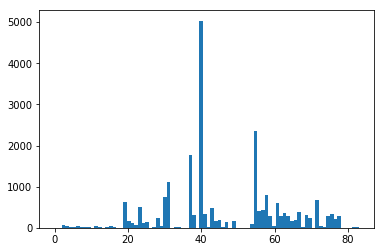

In [22]:
# distribution of items in each category is pretty uneven
plt.hist(items.item_category_id, bins=(items.item_category_id.nunique()))

### Shops

The shops dataframe has the same name + id pattern as the other ones. As before, these match 1:1.

There are 60 different shops.

shop_name seems to combine different sorts of information:

- The first part is usually a place (e.g. "Москва"). But there are a few exceptions -- e.g. "цифровой склад" apparently means "digital warehouse".

- The first part is usually a single word without spaces, even when the original is multiple words (e.g. "РостовНаДону" for "Ростов На Дону" ) -- but not always (e.g. "Сергиев Посад")

- The middle part looks like a description of the location type -- e.g. "ТЦ" for "торговый центр ("shopping centre") or "ТРЦ" for "торгово-развлекательный центр" ("shopping and entertainment centre").
see: (http://msk.ros-spravka.ru/catalog/trade_and_shops/chto_znachit_trts_i_tts_rasshifrovka_sokrashcheniy/ )

- The third part seems like a specific shop name or location (e.g. "Сити Молл" = City Mall?)

- The data seems to have been tidied already in a way that groups these three things together (e.g. with quotes). But there are some exceptions (e.g. Москва ТК "Буденовский" Y(пав.А2))

So: we should split the shop name into multiple columns, but deciding how to do this will need some thought.

Some shop names are duplicated, with a bit of rogue punctuation: "Якутск" and "!Якутск"

In [23]:
shops.head()

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

In [24]:
# one name per id and vice versa
names_per_id = shops.groupby('shop_id').shop_name.value_counts()
ids_per_name = shops.groupby('shop_name').shop_id.value_counts()
max(names_per_id), max(ids_per_name)

(1, 1)

In [25]:
# we have 60 shops
shops.shape

(60, 2)

In [94]:
# shop_name seems to combine different sorts of information:
shops.shop_name.head()

0     !Якутск Орджоникидзе, 56 фран
1     !Якутск ТЦ "Центральный" фран
2                  Адыгея ТЦ "Мега"
3    Балашиха ТРК "Октябрь-Киномир"
4          Волжский ТЦ "Волга Молл"
Name: shop_name, dtype: object

In [27]:
# "Якутск" vs "!Якутск" looks like an error
shops[shops.shop_name.str.contains('Якутск')]

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
57        Якутск Орджоникидзе, 56       57
58        Якутск ТЦ "Центральный"       58

In [28]:
# are these the same thing?
shops[shops.shop_name.str.contains('Буденовский')]

shop_name  shop_id
23  Москва ТК "Буденовский" (пав.А2)       23
24  Москва ТК "Буденовский" (пав.К7)       24

### Sales (train set)

The train data has almost 3 million records. It contains daily sales by shop and item. We also get the item_price, and a count of items sold that day. Some counts are -1, which presumably means a return. We also get date_block_num, which is the month number -- counting from 0 to 33 (and 34 is the test data, but that's not labelled).


According to the competition rules, "We are asking you to predict total sales for every product and store in the next month" (https://www.kaggle.com/c/competitive-data-science-final-project). But we *don't* get this in our train data, so we'll have do aggregate over each month.

The test period will cover the Christmas/New Year period, so we'd expect a strong seasonal effect. We should choose our local validation set with this in mind.

Some item counts and prices seem to be implausibly large or small (although we've been told that item_cnt_day = -1 means a return), so we might want to remove these rows.


In [10]:
sales_train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-01-02               0       59    22154      999.00           1.0
1 2013-01-03               0       25     2552      899.00           1.0
2 2013-01-05               0       25     2552      899.00          -1.0
3 2013-01-06               0       25     2554     1709.05           1.0
4 2013-01-15               0       25     2555     1099.00           1.0

In [11]:
# number of records
sales_train.shape

(2935849, 6)

In [12]:
# range of values
sales_train.agg({'item_price':['min', 'max'], 'item_cnt_day':['min', 'max']})


item_price  item_cnt_day
min        -1.0         -22.0
max    307980.0        2169.0

In [13]:
# do these really expensive items looks like problems with the data?
sales_train.sort_values('item_price', ascending=False).head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
1163158 2013-12-13              11       12     6066    307980.0           1.0
885138  2013-09-17               8       12    11365     59200.0           1.0
1488135 2014-03-20              14       25    13199     50999.0           1.0
2327159 2015-01-29              24       12     7241     49782.0           1.0
2931380 2015-10-20              33       22    13403     42990.0           1.0

In [14]:
# some of the items seem implausibly expensive - we might consider removing rows over some threshold
items[items.item_id.isin(sales_train.sort_values('item_price', ascending=False).head().item_id)]

item_name  item_id  \
6066                                Radmin 3  - 522 лиц.     6066   
7241   UserGate Proxy & Firewall 6.X с модулем фильтр...     7241   
11365                                     Доставка (EMS)    11365   
13199            Коллекционные шахматы (Властелин Колец)    13199   
13403  Комплект "Microsoft Xbox One 1TB  Limited Edit...    13403   

       item_category_id  
6066                 75  
7241                 75  
11365                 9  
13199                69  
13403                16

In [15]:
# One item has a negative price, which doesn't seem to be a special code for e.g. a returned item.
# There are some very cheap things (but maybe they are just discounted items)
sales_train.sort_values('item_price', ascending=True).head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683 2013-05-15               4       32     2973     -1.0000           1.0
608763 2013-06-08               5       58    11865      0.0700           1.0
579766 2013-06-11               5        6    11864      0.0700           1.0
611400 2013-06-08               5       58    20146      0.0875           4.0
673155 2013-07-31               6        6    11872      0.0900           1.0

In [16]:
items[items.item_id.isin(sales_train.sort_values('item_price', ascending=True).head().item_id)]

item_name  item_id  item_category_id
2973   DmC Devil May Cry [PS3, русские субтитры]     2973                19
11864              Змей ДЖЕККИ с сердечком 36 см    11864                63
11865                Змей МАКС антистресс 33 см.    11865                63
11872                        Змея ВАСИЛИСА 23 см    11872                63
20146       Удавчик Плюшевый: 75см. (яйцо ткань)    20146                63

In [17]:
# some item counts look excessive
sales_train.sort_values('item_cnt_day', ascending=False).head()

date  date_block_num  shop_id  item_id   item_price  \
2909818 2015-10-28              33       12    11373     0.908714   
2326930 2015-01-15              24       12    20949     4.000000   
2864235 2015-09-30              32       12     9248  1692.526158   
2851091 2015-09-30              32       55     9249  1702.825746   
2608040 2015-04-14              27       12     3731  1904.548077   

         item_cnt_day  
2909818        2169.0  
2326930        1000.0  
2864235         669.0  
2851091         637.0  
2608040         624.0

In [18]:
items[items.item_id.isin(sales_train.sort_values('item_cnt_day', ascending=False).head().item_id)]

item_name  item_id  \
3731           Grand Theft Auto V [PC, русские субтитры]     3731   
9248   Билет "ИгроМир 2015" - 3 октября 2015 (сайт) [...     9248   
9249   Билет "ИгроМир 2015" - 3 октября 2015 (сайт) У...     9249   
11373               Доставка до пункта выдачи (Boxberry)    11373   
20949  Фирменный пакет майка 1С Интерес белый (34*42)...    20949   

       item_category_id  
3731                 30  
9248                 80  
9249                  8  
11373                 9  
20949                71

(array([2.00000e+00, 7.35400e+03, 2.91964e+06, 5.97100e+03, 1.57900e+03,
        6.05000e+02, 2.65000e+02, 1.28000e+02, 6.40000e+01, 6.30000e+01,
        2.70000e+01, 4.00000e+01, 1.60000e+01, 1.30000e+01, 1.20000e+01,
        1.60000e+01, 5.00000e+00, 6.00000e+00, 2.00000e+00, 2.00000e+00,
        4.00000e+00, 1.00000e+00, 3.00000e+00, 2.00000e+00, 1.00000e+00,
        2.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00,
        2.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 3.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 6.00000e+00, 1.00000e+00, 0.00000e+00,
        2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

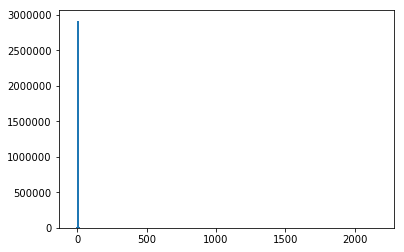

In [19]:
# distribution of target values (or at least the daily item counts)
plt.hist(sales_train.item_cnt_day, bins=(sales_train.item_cnt_day.nunique()))

In [20]:
# date_block_num goes from 0-33
min(sales_train.date_block_num), max(sales_train.date_block_num)

(0, 33)

In [21]:
# useful to look at weekdays
sales_train.assign( weekday = sales_train.date.dt.weekday_name).groupby('weekday').agg('count')

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
weekday                                                                      
Friday     439298          439298   439298   439298      439298        439298
Monday     337074          337074   337074   337074      337074        337074
Saturday   590359          590359   590359   590359      590359        590359
Sunday     503104          503104   503104   503104      503104        503104
Thursday   367280          367280   367280   367280      367280        367280
Tuesday    345772          345772   345772   345772      345772        345772
Wednesday  352962          352962   352962   352962      352962        352962

In [22]:
sales_train.query('date_block_num==1').sort_values('date', ascending=True).date.unique()

array(['2013-02-01T00:00:00.000000000', '2013-02-02T00:00:00.000000000',
       '2013-02-03T00:00:00.000000000', '2013-02-04T00:00:00.000000000',
       '2013-02-05T00:00:00.000000000', '2013-02-06T00:00:00.000000000',
       '2013-02-07T00:00:00.000000000', '2013-02-08T00:00:00.000000000',
       '2013-02-09T00:00:00.000000000', '2013-02-10T00:00:00.000000000',
       '2013-02-11T00:00:00.000000000', '2013-02-12T00:00:00.000000000',
       '2013-02-13T00:00:00.000000000', '2013-02-14T00:00:00.000000000',
       '2013-02-15T00:00:00.000000000', '2013-02-16T00:00:00.000000000',
       '2013-02-17T00:00:00.000000000', '2013-02-18T00:00:00.000000000',
       '2013-02-19T00:00:00.000000000', '2013-02-20T00:00:00.000000000',
       '2013-02-21T00:00:00.000000000', '2013-02-22T00:00:00.000000000',
       '2013-02-23T00:00:00.000000000', '2013-02-24T00:00:00.000000000',
       '2013-02-25T00:00:00.000000000', '2013-02-26T00:00:00.000000000',
       '2013-02-27T00:00:00.000000000', '2013-02-28

In [49]:
# date_block_num seems to be the calendar month, counting from January 2013
sales_train.groupby('date_block_num').agg({'date':['min','max', 'nunique']} )

date                    
                       min         max nunique
date_block_num                                
0               01.01.2013  31.01.2013      31
1               01.02.2013  28.02.2013      28
2               01.03.2013  31.03.2013      31
3               01.04.2013  30.04.2013      30
4               01.05.2013  31.05.2013      31
5               01.06.2013  30.06.2013      30
6               01.07.2013  31.07.2013      31
7               01.08.2013  31.08.2013      31
8               01.09.2013  30.09.2013      30
9               01.10.2013  31.10.2013      31
10              01.11.2013  30.11.2013      30
11              01.12.2013  31.12.2013      31
12              01.01.2014  31.01.2014      31
13              01.02.2014  28.02.2014      28
14              01.03.2014  31.03.2014      31
15              01.04.2014  30.04.2014      30
16              01.05.2014  31.05.2014      31
17              01.06.2014  30.06.2014      30
18              01.07.2014  31.07.2014      31
19              01.08.2014  31.08.2014      31
20              01.09.2014  30.09.2014      30
21              01.10.2014  31.10.2014      31
22              01.11.2014  30.11.2014      30
23              01.12.2014  31.12.2014      31
24              01.01.2015  31.01.2015      31
25              01.02.2015  28.02.2015      28
26              01.03.2015  31.03.2015      31
27              01.04.2015  30.04.2015      30
28              01.05.2015  31.05.2015      31
29              01.06.2015  30.06.2015      30
30              01.07.2015  31.07.2015      31
31              01.08.2015  31.08.2015      31
32              01.09.2015  30.09.2015      30
33              01.10.2015  31.10.2015      31

## Time trend

There is an overall downward trend in sales, but with peaks at 12 month intervals.

In [53]:
monthly_sales_count = sales_train.groupby('date_block_num').agg({'item_cnt_day':['sum']} )

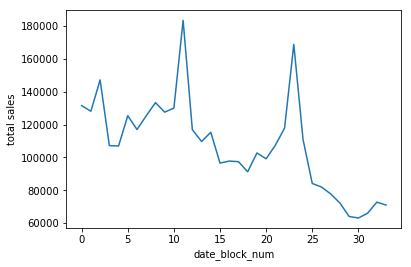

In [56]:
plt.plot(monthly_sales_count)
plt.xlabel('date_block_num')
plt.ylabel('total sales')
plt.show()

### Sample submission

This is pretty straightforward: we are submitting a value of item_cnt_month for each row in the test data.

In [25]:
sample_submission.head()

ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5
3   3             0.5
4   4             0.5

In [26]:
sample_submission.shape, test_csv.shape

((214200, 2), (214200, 3))

### Test data

Each row has a shop_id and item_id. There also a variable just called ID which seems to function as a row index.

There's no explict date here, but the competition rules say "We are asking you to predict total sales for every product and store in the next month" (https://www.kaggle.com/c/competitive-data-science-final-project). This seems to mean that we're predicting for date_block_num == 34

All the shop_ids in the test data are present in the train data. But but there are some item_ids in the test data that are *not* in the train data. We'll have to create entries for the 'missing' shop_id / item_id combinations, with some kind of guess about their sales.





In [37]:
test.head()

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268

In [39]:
# any duplicate shop_id/item_id combinations?
test.groupby(['shop_id', 'item_id']).filter(lambda x: len(x) > 1)

Empty DataFrame
Columns: [ID, shop_id, item_id]
Index: []

In [40]:
# any shop_id not in sales_train data?
sum(test.shop_id.isin(sales_train.shop_id) != True)

0

In [41]:
# any item_id not in sales_train data?
sum(test.item_id.isin(sales_train.item_id) == False)

15246

In [42]:
# for example, this item is not in sales_train ...
sales_train.query('item_id == 5268')

Empty DataFrame
Columns: [date, date_block_num, shop_id, item_id, item_price, item_cnt_day]
Index: []

In [43]:
# ...but we do have it in the items df
items.query('item_id == 5268')

item_name  item_id  item_category_id
5268  Need for Speed [PS4, русская версия]     5268                20

In [46]:
# item_name, shop_name and item_category_name are straightforwardly usable -- we can just look them up in the relevant places:

# all shops in the test data are in the shops df
assert(len([x for x in test.shop_id if x not in shops.shop_id]) == 0)

# all items in the test data are in the items df
assert(len([x for x in test.item_id if x not in items.item_id]) == 0)

# all shops in the test data are also in the main sales data
assert(len([x for x in test.shop_id if x not in sales_train.shop_id]) == 0)

# all items in the test data are also in the main sales data
assert(len([x for x in test.item_id if x not in sales_train.item_id]) == 0)

# all items in the items data (and therefore in test) are in item categories
assert(len([x for x in items.item_category_id if x not in item_categories.item_category_id]) == 0)